In [2]:
from vit_jax import models
import jax
import jax.numpy as jnp
from PIL import Image
import numpy as np
import glob
import os

2023-08-18 21:26:57.751432: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
model_name = 'LiT-B16B'
lit_model = models.get_model(model_name)
lit_variables = lit_model.load_variables()
tokenizer = lit_model.get_tokenizer()
image_preprocessing = lit_model.get_image_preprocessing()
pp = lit_model.get_pp()


In [20]:
@jax.jit
def embed_images(variables, images):
  zimg, _, _ = lit_model.apply(variables, images=images)
  return zimg


In [21]:
des_path =  "data/LIT_Features/"
paths = "data/KeyFramesC00_V00/"

os.system('TF_CPP_MIN_LOG_LEVEL=0')
video_paths = sorted(glob.glob(f"{paths}/*/"))
video_paths = ['/'.join(i.split('/')[:-1]) for i in video_paths]

os.makedirs(des_path, exist_ok=True)

import time
start_time = time.time()

flag = 0
for vd_path in video_paths:
  print(vd_path)
  # check_file = int(vd_path.split('/')[-1].replace('C02_V',''))
  # if check_file <= 349:
  #   print(f"Skip: {vd_path}")
  #   continue

  re_feats = []
  keyframe_paths = glob.glob(f'{vd_path}/*.jpg')
  keyframe_paths = sorted(keyframe_paths, key=lambda x : x.split('/')[-1].replace('.jpg',''))

  for keyframe_path in keyframe_paths:
    image = image_preprocessing([Image.open(keyframe_path)])

    image_feats = embed_images(lit_variables, image)
    image_feats = np.array(image_feats)

    
    if flag == 0:
      print("Image feat: ", image_feats.shape)
      flag = 1

    re_feats.append(image_feats)

  name_npy = vd_path.split('/')[-1]
  outfile = f'{des_path}/{name_npy}.npy'
  np.save(outfile, re_feats)

print ("Time to extract image features and export npy . file by LIT: ", time.time() - start_time) 

data/KeyFramesC00_V00/C00_V0000
Image feat:  (1, 768)
data/KeyFramesC00_V00/C00_V0001
Time to extract image features and export npy . file by LIT:  549.8236835002899


In [5]:
import numpy as np
import faiss
import glob
import json
import matplotlib.pyplot as plt
import os
import math
import pandas as pd
import re
import time

from langdetect import detect

In [11]:
class File4Faiss:
  def __init__(self, root_database: str):
    self.root_database = root_database

  def re_shot_list(self, shot_list, id, k):
    len_lst = len(shot_list)
    if k>=len_lst or k == 0:
      return shot_list

    shot_list.sort()
    index_a = shot_list.index(id)

    index_get_right = k // 2
    index_get_left = k - index_get_right

    if index_a - index_get_left < 0:
      index_get_left = index_a
      index_get_right = k - index_a
    elif index_a + index_get_right >= len_lst:
      index_get_right = len_lst - index_a - 1
      index_get_left = k - index_get_right

    output = shot_list[index_a - index_get_left: index_a] + shot_list[index_a: index_a + index_get_right + 1]
    return output

  def write_json_file(self, json_path: str, shot_frames_path: str, option='full'):
    count = 0
    self.infos = []
    des_path = os.path.join(json_path, "keyframes_id.json")
    keyframe_paths = sorted(glob.glob(f'{self.root_database}/KeyFramesC0*'))

    for kf in keyframe_paths:
      video_paths = sorted(glob.glob(f"{kf}/*"))

      for video_path in video_paths:
        image_paths = sorted(glob.glob(f'{video_path}/*.jpg'))

        ###### Get all id keyframes from video_path ######
        id_keyframes = np.array([int(id.split('/')[-1].replace('.jpg', '')) for id in image_paths])

        ###### Get scenes from video_path ######
        video_info = video_path.split('/')[-1]
        
        with open(f'{shot_frames_path}/{video_info}.txt', 'r') as f:
          lst_range_shotes = f.readlines()
        lst_range_shotes = np.array([re.sub('\[|\]', '', line).strip().split(' ') for line in lst_range_shotes]).astype(np.uint32)

        for im_path in image_paths:
          # im_path = 'Database/' + '/'.join(im_path.split('/')[-3:])
          id = int(im_path.split('/')[-1].replace('.jpg', ''))
          
          i = 0
          flag=0
          for range_shot in lst_range_shotes:
            i+=1
            first, end = range_shot

            if first <= id <= end:
              break
            
            if i == len(lst_range_shotes):
              flag=1
          
          if flag == 1:
            print(f"Skip: {im_path}")
            print(first, end)
            continue

          ##### Get List Shot ID #####
          lst_shot = id_keyframes[np.where((id_keyframes>=first) & (id_keyframes<=end))]
          lst_shot = self.re_shot_list(list(lst_shot), id, k=6)
          lst_shot = [f"{i:0>6d}" for i in lst_shot]

          ##### Get List Shot Path #####
          lst_shot_path = []
          for id_shot in lst_shot:
            info_shot = {
                "shot_id": id_shot,
                "shot_path": '/'.join(im_path.split('/')[:-1]) + f"/{id_shot}.jpg"
            }
            lst_shot_path.append(info_shot) 

          ##### Merge All Info #####
          info = {
                  "image_path": im_path,
                  "list_shot_id": lst_shot,
                  "list_shot_path": lst_shot_path
                 }
                  
          if option == 'full':        
            self.infos.append(info)   
          else:
            if id == (end+first)//2:
              self.infos.append(info)  

          count += 1

    id2img_fps = dict(enumerate(self.infos))
    
    with open(des_path, 'w') as f:
      f.write(json.dumps(id2img_fps))

    print(f'Saved {des_path}')
    print(f"Number of Index: {count}")

  def load_json_file(self, json_path: str):
    with open(json_path, 'r') as f:
      js = json.loads(f.read())

    return {int(k):v for k,v in js.items()}

  def write_bin_file(self, bin_path: str, json_path: str, method='L2', feature_shape=768): # Edit 512, 768
    count = 0
    id2img_fps = self.load_json_file(json_path)

    if method in 'L2':
      index = faiss.IndexFlatL2(feature_shape)
    elif method in 'cosine':
      index = faiss.IndexFlatIP(feature_shape)
    else:
      assert f"{method} not supported"
    
    for _, value in id2img_fps.items():
      image_path = value["image_path"]
      video_name = image_path.split('/')[-2] + '.npy'

      video_id = re.sub('_V\d+', '', image_path.split('/')[-2])
      batch_name = image_path.split('/')[-3].split('_')[-1]
      clip_name = f"LIT_Features" # Edit 

      feat_path = os.path.join(self.root_database, clip_name, video_name) 

      feats = np.load(feat_path)

      ids = os.listdir(re.sub('/\d+.jpg','',image_path))
      ids = sorted(ids, key=lambda x:int(x.split('.')[0]))

      id = ids.index(image_path.split('/')[-1])
      
      feat = feats[id]
      # print(feat.shape)
      feat = feat.astype(np.float32).reshape(1,-1)
      # print("##########################################")
      # print(" Feat after reshape: ", feat.shape)
      index.add(feat)
      
      count += 1
    
    faiss.write_index(index, os.path.join(bin_path, f"faiss_LIT_{method}.bin"))

    print(f'Saved {os.path.join(bin_path, f"faiss_LIT_{method}.bin")}')
    print(f"Number of Index: {count}")

In [12]:
create_file = File4Faiss('data')
# create_file.write_json_file(json_path='data/faiss_merge_files', shot_frames_path='data/scenes_txt')
create_file.write_bin_file(bin_path='data/faiss_merge_files', json_path='data/faiss_merge_files/keyframes_id.json', method='cosine')

Saved data/faiss_merge_files/faiss_LIT_cosine.bin
Number of Index: 2299


In [2]:
import googletrans
import translate
import re


class Translation:
    def __init__(self, from_lang='vi', to_lang='en', mode='google'):
        # The class Translation is a wrapper for the two translation libraries, googletrans and translate. 
        self.__mode = mode
        self.__from_lang = from_lang
        self.__to_lang = to_lang

        if mode in 'googletrans':
            self.translator = googletrans.Translator()
        elif mode in 'translate':
            self.translator = translate.Translator(from_lang=from_lang,to_lang=to_lang)

    def preprocessing(self, text):
        """
        It takes a string as input, and returns a string with all the letters in lowercase
        :param text: The text to be processed
        :return: The text is being returned in lowercase.
        """
        return text.lower()

    def __call__(self, text):
        """
        The function takes in a text and preprocesses it before translation
        :param text: The text to be translated
        :return: The translated text.
        """
        text = self.preprocessing(text)
        return self.translator.translate(text) if self.__mode in 'translate' \
                else self.translator.translate(text, dest=self.__to_lang).text



class MyFaiss:
  def __init__(self, root_database: str, bin_file: str, json_path: str):    
    self.index = self.load_bin_file(bin_file)
    self.id2img_fps = self.load_json_file(json_path)

    self.translater = Translation()

    
  def load_json_file(self, json_path: str):
      with open(json_path, 'r') as f:
        js = json.loads(f.read())

      return {int(k):v for k,v in js.items()}

  def load_bin_file(self, bin_file: str):
    return faiss.read_index(bin_file)

  def show_images(self, image_paths):
    fig = plt.figure(figsize=(15, 10))
    columns = int(math.sqrt(len(image_paths)))
    rows = int(np.ceil(len(image_paths)/columns))

    for i in range(1, columns*rows +1):
      img = plt.imread(image_paths[i - 1])
      ax = fig.add_subplot(rows, columns, i)
      ax.set_title('/'.join(image_paths[i - 1].split('/')[-3:]))

      plt.imshow(img)
      plt.axis("off")
      
    plt.show()

  def text_search(self, text, k):

    start_time = time.time()
    if detect(text) == 'vi':
      text = self.translater(text)

    os.system('TF_CPP_MIN_LOG_LEVEL=0')
    model_name = 'LiT-B16B'
    lit_model = models.get_model(model_name)
    tokenizer = lit_model.get_tokenizer()
    lit_variables = lit_model.load_variables()
    ###### TEXT FEATURES EXACTING ######
    tokens = tokenizer([text])
    _, data_embedding, _ = lit_model.apply(lit_variables, tokens=tokens)
    Ex_time = time.time() - start_time
    print("Execute time", Ex_time)

    
    ###### SEARCHING #####
    search_time = time.time()
    scores, idx_image = self.index.search(data_embedding, k=k)
    idx_image = idx_image.flatten()

    ###### GET INFOS KEYFRAMES_ID ######
    infos_query = list(map(self.id2img_fps.get, list(idx_image)))
    image_paths = [info['image_path'] for info in infos_query]
    ex_search = time.time() - search_time
    print("Execute search", ex_search)
    # lst_shot = [info['list_shot_id'] for info in infos_query]


    return scores, idx_image, image_paths


⚠️ Reusing local copy: LiT-B16B.npz
Execute time 11.480314493179321
Execute search 0.0010428428649902344


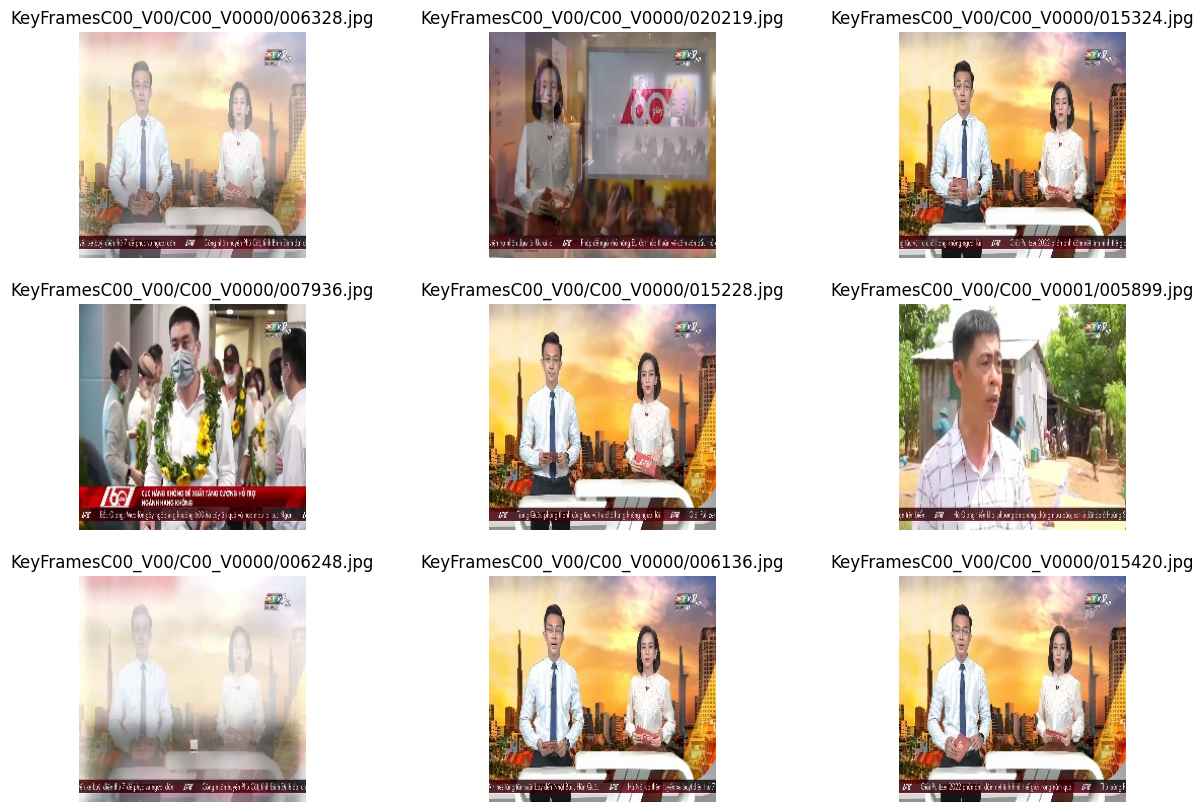

In [30]:
def main():
  ##### TESTING #####
  bin_file='data/faiss_merge_files/faiss_LIT_cosine.bin'
  json_path = 'data/faiss_merge_files/keyframes_id.json'

  cosine_faiss = MyFaiss('./Database', bin_file, json_path)


  ##### TEXT SEARCH #####
  text = 'MC dẫn chương trình mặc áo sơ mi trắng'

  
  scores, infos_query, image_paths = cosine_faiss.text_search(text, k=9)
  # cosine_faiss.write_csv(infos_query, des_path_submit='./')
  cosine_faiss.show_images(image_paths)

if __name__ == "__main__":
    main()

number of GPUs: 1


Indexing features to faiss: 100%|██████████| 2299/2299 [00:05<00:00, 403.36it/s]


Saved to:  models/faiss_LIT_cosine.bin
Translated text:  Two people are hosting the program

⚠️ Reusing local copy: LiT-B16B.npz
Time inference of lit: 11.909035921096802


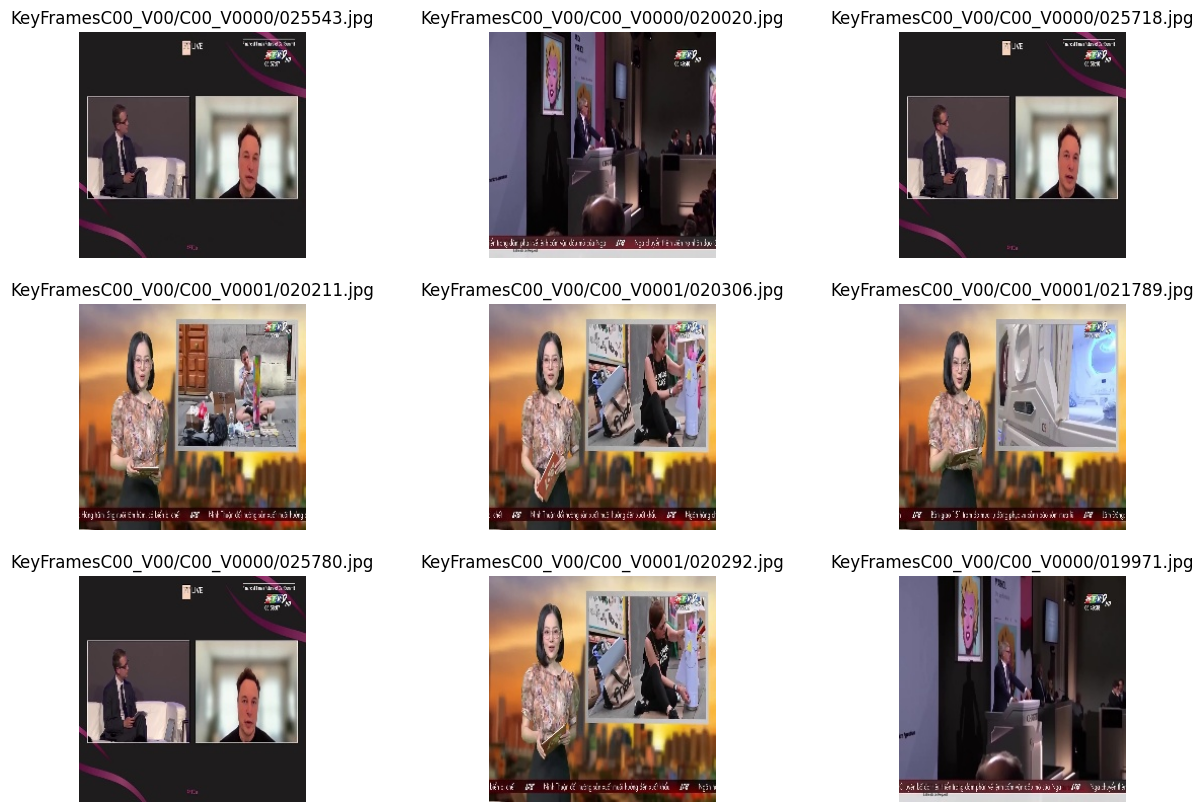

Time inference of lit: 0.11286425590515137


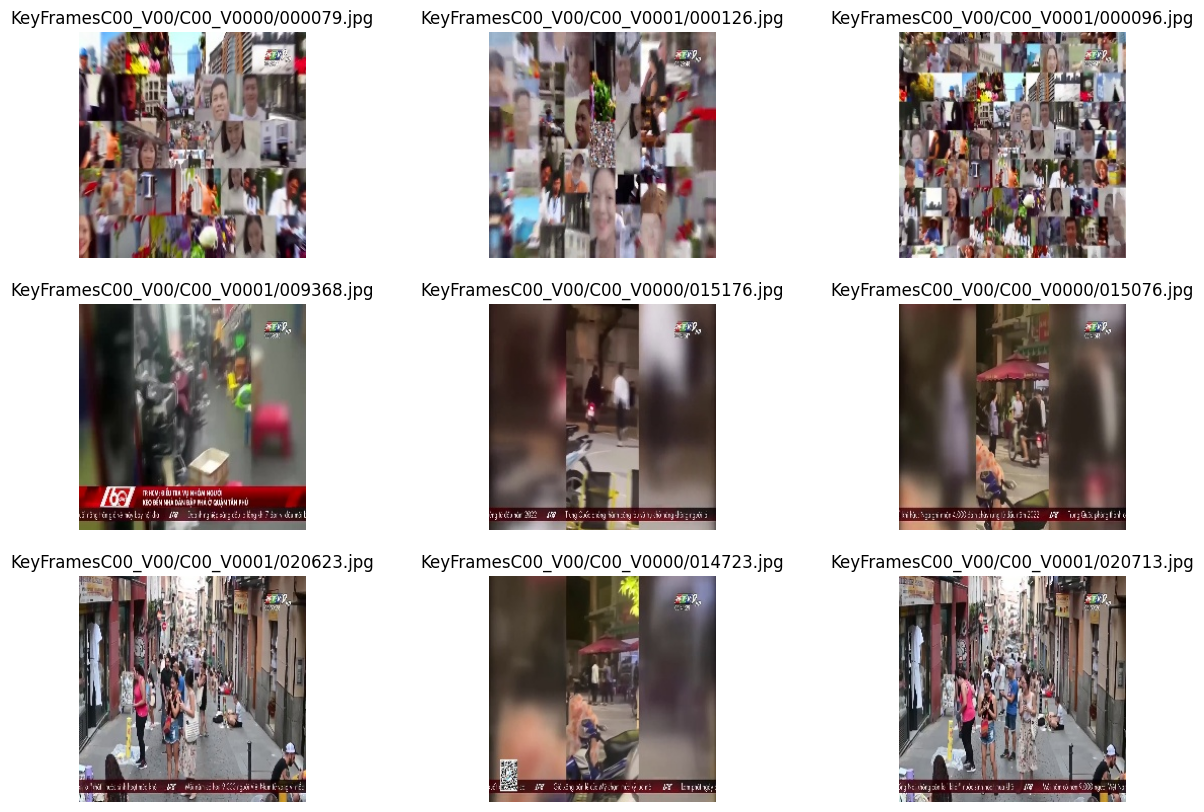

In [4]:
import faiss
import json
import matplotlib.pyplot as plt
import math
import os
import sys
from pathlib import Path
import time
import numpy as np
import tqdm
import re
from vit_jax import models
from langdetect import detect
import pandas as pd
import torch



mode_compute = 'lit'
#define useful path
WORK_DIR = ""
data_path = os.path.join("./data")
folder_features = ("./data")
keyframes_id_path = os.path.join(data_path, 'faiss_merge_files/keyframes_id.json')
bin_path = os.path.join(folder_features, "faiss_merge_files/faiss_LIT_cosine.bin")
result_path = os.path.join("data", 'results')
mode_result_path = os.path.join(result_path, mode_compute)

def time_complexity(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        results = func(*args, **kwargs)
        print('Time inference of {}: {}'.format(args[0].mode, time.time() - start))
        return results
    return wrapper

class FaissSearch(Translation):

    def __init__(self, folder_features=folder_features, annotation=keyframes_id_path, mode='lit'):
        super(FaissSearch, self).__init__()
        self.mode = mode
        self.cpu_index = None
        self.folder_features = folder_features # folder feature path
        self.keyframes_id = self.load_json_file(annotation) # read keyframes_id.json
        self.query = {
            'encoder': [],
            'k': 1
        }
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


    def load_json_file(self, json_path: str):
        with open(json_path, 'r') as f:
            js = json.loads(f.read())
        return js
    

    @time_complexity
    def text_search(self, text, k):
        text_features = self.get_mode_extract(text, method='text')
        text_features = np.array(text_features.reshape(1, -1))  # Reshape to 2D array
        gpu_index = faiss.index_cpu_to_all_gpus(self.cpu_index)
        scores, idx_image = gpu_index.search(text_features, k=k)

        idx_image = idx_image.flatten()

        image_paths = [self.keyframes_id[str(item)]['image_path'] for item in list(idx_image)]
        image_paths = list(map(lambda x: x.replace("Database", 'data/news'), image_paths))

        return scores, idx_image, image_paths
    

    @time_complexity
    def image_search(self, image_id, k):
        query_feats = self.cpu_index.reconstruct(image_id).reshape(1,-1)
        gpu_index = faiss.index_cpu_to_all_gpus(self.cpu_index)
        scores, idx_image = gpu_index.search(query_feats, k=k)
        idx_image = idx_image.flatten()

        image_paths = [self.keyframes_id[str(item)]['image_path'] for item in list(idx_image)]
        image_paths = list(map(lambda x: x.replace("Database", 'data/news'), image_paths))

        
        return scores, idx_image, image_paths

    def video_search(self, video, k):
        pass

    def get_mode_extract(self, data, method='text'):
        if method == 'text':
            if detect(data) == 'vi':
                text = Translation.__call__(self, data)
            print('Translated text: ', text)
            if self.mode == 'lit':
                os.system('TF_CPP_MIN_LOG_LEVEL=0')
                model_name = 'LiT-B16B'
                lit_model = models.get_model(model_name)
                tokenizer = lit_model.get_tokenizer()
                lit_variables = lit_model.load_variables()
                tokens = tokenizer([text])
                _, data_embedding, _ = lit_model.apply(lit_variables, tokens=tokens)
            elif self.mode == 'clip':
                print('Translated text: ', text)
                text = clip.tokenize([text]).to(self.device)
                model, preprocess = clip.load("ViT-B/16", device=self.device) 
                # with torch.no_grad(): 
                data_embedding = model.encode_text(text)
                # data_embedding /= data_embedding.norm(dim=-1, keepdim=True)
                data_embedding = data_embedding.cpu().detach().numpy().astype(np.float32)
            else:
                print(f'Not found model {self.mode}')


        elif method == 'image':
            pass

        return data_embedding
    

    def indexing(self, VECTOR_DIMENSIONS):
        self.cpu_index = faiss.IndexFlatIP(VECTOR_DIMENSIONS)
        gpu_index = faiss.index_cpu_to_all_gpus(  # build the index
            self.cpu_index
        )
        for values in tqdm.tqdm(self.keyframes_id.values(),desc='Indexing features to faiss'):
            image_path = values["image_path"]
            image_path = image_path.replace("data/", 'data/')
            video_name = image_path.split('/')[-2] + '.npy'
            if video_name == 'C00_V0002.npy':
               break
            video_id = re.sub('_V\d+', '', image_path.split('/')[-2])
            batch_name = image_path.split('/')[-3].split('_')[-1]
            lip_name = f"LIT_Features/"
            feat_path = os.path.join(self.folder_features, lip_name, video_name)
            feats = np.load(feat_path)
            ids = os.listdir(re.sub('/\d+.jpg','',os.path.join(WORK_DIR, image_path)))
            ids = sorted(ids, key=lambda x:int(x.split('.')[0]))
            id = ids.index(image_path.split('/')[-1])
            feat = feats[id]
            feat = feat.astype(np.float32).reshape(1,-1)
            # add feature to faiss
            gpu_index.add(feat)
        self.cpu_index = faiss.index_gpu_to_cpu(gpu_index)
        faiss.write_index(self.cpu_index, os.path.join(WORK_DIR, 'data/faiss_merge_files', f'faiss_LIT_cosine.bin'))
        print('Saved to: ', os.path.join(WORK_DIR, 'models', f'faiss_LIT_cosine.bin'))

    def load_bin_file(self, bin_file=bin_path):
        self.cpu_index = faiss.read_index(bin_file)

    def show_images(self, image_paths, save_path, method='text'):
        fig = plt.figure(figsize=(15, 10))
        columns = int(math.sqrt(len(image_paths)))
        rows = int(np.ceil(len(image_paths)/columns))
        

        for i in range(1, columns*rows +1):
            img = plt.imread(os.path.join(WORK_DIR, image_paths[i - 1]))
            ax = fig.add_subplot(rows, columns, i)
            ax.set_title('/'.join(image_paths[i - 1].split('/')[-3:]))

            plt.imshow(img)
            plt.axis("off")
            plt.savefig(os.path.join(save_path, f'{method}_retrieval.jpg'))
        plt.show()



def main():

    if not os.path.exists(os.path.join(result_path)):
        os.makedirs(result_path)

    if not os.path.exists(os.path.join(mode_result_path)):
        os.makedirs(mode_result_path)

    # Create an object vector search
    faiss_search = FaissSearch(folder_features, keyframes_id_path, mode=mode_compute)

    ngpus = faiss.get_num_gpus()
    print("number of GPUs:", ngpus)
    # Load and save features to file.bin in faiss
    faiss_search.indexing(VECTOR_DIMENSIONS=768) #
    faiss_search.load_bin_file(bin_path)

    # text search: text2image, text, asr2text, ocr
    text = 'Hai người đang dẫn chương trình'
    scores, images_id, image_paths = faiss_search.text_search(text, k=9)
    df_text = pd.DataFrame({'images_id': list(images_id), 'scores': scores[0]})
    df_text.to_csv(os.path.join(mode_result_path, f'text_retrieval.csv'))
    faiss_search.show_images(image_paths, mode_result_path, method='text')
    
    # image search: image2text, image, asr2text, ocr
    scores, images_id, image_paths = faiss_search.image_search(image_id=2, k=9)
    faiss_search.show_images(image_paths, mode_result_path, method='image')
    df_images = pd.DataFrame({'images_idl': list(images_id), 'scores': scores[0]})
    df_images.to_csv(os.path.join(mode_result_path, f'image_retrieval.csv'))
    # video search: image2text, image, asr2text, ocr


if __name__ == "__main__":
    main()